In [1]:
import os
import torch
import numpy as np
import random
from utils import buildDataset

## build dataset

In [2]:
defaultStrategy = "./DefaultStrategy.txt"
defaultOutput = "./defaultOutputs.txt"
strategy = "./strategy.txt"
output = "./outputs.txt"
dataset = buildDataset.getData(strategy, output, defaultStrategy, defaultOutput)

In [3]:
len(dataset)

77

In [4]:
dataset[0]

[[{'size': 7,
   'offset': 0,
   'mazeEndIter': 3,
   'MarkerCost': 0,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  10178],
 [{'size': 7,
   'offset': -2,
   'mazeEndIter': 3,
   'MarkerCost': 8,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  569],
 [{'size': 7,
   'offset': -5,
   'mazeEndIter': 3,
   'MarkerCost': 8,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  499],
 [{'size': 7,
   'offset': 0,
   'mazeEndIter': 8,
   'MarkerCost': 32,
   'FixedShapeCost': 16,
   'Decay': 0.95,
   'ripupMode': 1,
   'followGuide': 0},
  1],
 [{'size': 7,
   'offset': -1,
   'mazeEndIter': 8,
   'MarkerCost': 32,
   'FixedShapeCost': 16,
   'Decay': 0.95,
   'ripupMode': 1,
   'followGuide': 0},
  0]]

# Turning datapoint to tensor

To represent a single data point input, we use a tensor of size <No_Strategy x 1 x 9>. (9 includes 8 DRC sequence items, and 1 output DRC value)

In [5]:
Dataset = buildDataset.datasetToTensor(dataset)

In [6]:
len(Dataset)

77

In [7]:
Dataset[0]

tensor([[[ 7.0000e+00,  0.0000e+00,  3.0000e+00,  0.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  1.0178e+04]],

        [[ 7.0000e+00, -2.0000e+00,  3.0000e+00,  8.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  1.0178e+04]],

        [[ 7.0000e+00, -5.0000e+00,  3.0000e+00,  8.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  5.6900e+02]],

        [[ 7.0000e+00,  0.0000e+00,  8.0000e+00,  3.2000e+01,  1.6000e+01,
           9.5000e-01,  1.0000e+00,  0.0000e+00,  4.9900e+02]],

        [[ 7.0000e+00, -1.0000e+00,  8.0000e+00,  3.2000e+01,  1.6000e+01,
           9.5000e-01,  1.0000e+00,  0.0000e+00,  1.0000e+00]]])

In [8]:
Dataset[0].size()

torch.Size([5, 1, 9])

# train-test split of the dataset

In [9]:
trainningSet, testSet = buildDataset.splitDataset(Dataset, trainSize = 0.7)

In [10]:
len(trainningSet)

53

In [11]:
len(testSet)

24

In [12]:
trainningSet[0]

tensor([[[  7.0000,   0.0000,   3.0000,   0.0000,   8.0000,   0.9500,   0.0000,
            1.0000, 247.0000]],

        [[  7.0000,  -2.0000,   3.0000,   8.0000,   8.0000,   0.9500,   0.0000,
            1.0000, 247.0000]],

        [[  7.0000,  -5.0000,   3.0000,   8.0000,   8.0000,   0.9500,   0.0000,
            1.0000,  20.0000]],

        [[  7.0000,   0.0000,   8.0000,  32.0000,  16.0000,   0.9500,   1.0000,
            0.0000,  11.0000]]])

In [13]:
trainningSet[0].size()

torch.Size([4, 1, 9])

# Creating the Network

In [15]:
# reference: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, inputData, hidden):
        combined = torch.cat((inputData, hidden), dim=1)
        hidden = self.i2h(self.relu(combined))
        output = self.h2o(self.relu(hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
n_input = len(trainningSet[0][0][0])
n_hidden = 10

In [17]:
n_input

9

In [18]:
n_output = 1

In [19]:
model = RNN(n_input, n_hidden, n_output)

# Run a step of the network

To run a step of this network we need to pass an input (in our case, the Tensor for the current strategy) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of drcs) and a next hidden state (which we keep for the next step).

In [20]:
import torch

In [21]:
inputStrategy = trainningSet[0][0]
hidden = torch.zeros(1, n_hidden)

output, next_hidden = model(inputStrategy, hidden)

In [22]:
next_hidden

tensor([[ 27.2640, -34.3298,  -5.1561,  30.7957,  18.1917,  20.0021,  28.9864,
         -39.7147, -24.7524,  42.6986]], grad_fn=<AddmmBackward0>)

In [23]:
output

tensor([[21.9538]], grad_fn=<AddmmBackward0>)

# Training

In [24]:
criterion = nn.MSELoss()

In [25]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

In [26]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
n_iters = 10000
print_every = 10
plot_every = 1

In [38]:
def train(x, model):
    hidden = model.initHidden()
    model.zero_grad()
    y = []
    results = []
    for i in range(x.size()[0]):
        output, hidden = model(x[i], hidden)
        y.append(x[i][0][-1])
        results.append(output[0][0])
        
    y = torch.Tensor(y).reshape(-1, 1, x.size()[0])
    results = torch.Tensor(results).reshape(-1, 1, x.size()[0])
    loss = criterion(output, y)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [39]:
import time
import math

In [40]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [41]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [42]:
for iter in range(1, n_iters + 1):
    # randomly generate an index in training set
    index = random.randint(0, len(trainningSet) - 1)
    x = trainningSet[index]
    output, loss = train(x, model)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/jborg/anaconda3/envs/DLPnR/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 28])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/jborg/anaconda3/envs/DLPnR/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/jborg/anaconda3/envs/DLPnR/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 6])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to

10 0% (0m 0s) 219600656.0000
20 0% (0m 0s) 48745196.0000
30 0% (0m 0s) 245233440.0000
40 0% (0m 0s) 73086936.0000
50 0% (0m 0s) 1908083712.0000
60 0% (0m 0s) 1904143744.0000
70 0% (0m 0s) 219810096.0000
80 0% (0m 0s) 15930.5215
90 0% (0m 0s) 738979584.0000
100 1% (0m 0s) 14876445.0000
110 1% (0m 0s) 24649108.0000
120 1% (0m 0s) 3425709312.0000
130 1% (0m 0s) 249185104.0000
140 1% (0m 0s) 49668924.0000
150 1% (0m 0s) 49988936.0000
160 1% (0m 0s) 32810292.0000
170 1% (0m 0s) 23662996.0000
180 1% (0m 0s) 158495072.0000
190 1% (0m 0s) 57109092.0000
200 2% (0m 0s) 775655232.0000
210 2% (0m 0s) 54178024.0000
220 2% (0m 0s) 7147184.5000
230 2% (0m 0s) 15544.4590
240 2% (0m 0s) 250566080.0000
250 2% (0m 0s) 6214089.0000
260 2% (0m 1s) 248517184.0000
270 2% (0m 1s) 51809640.0000
280 2% (0m 1s) 225542560.0000
290 2% (0m 1s) 65180588.0000
300 3% (0m 1s) 235682.2812
310 3% (0m 1s) 10471077.0000
320 3% (0m 1s) 244902816.0000
330 3% (0m 1s) 1903975808.0000
340 3% (0m 1s) 737479424.0000
350 3% (0m 1s

2810 28% (0m 5s) 1484610816.0000
2820 28% (0m 5s) 74316016.0000
2830 28% (0m 5s) 670478848.0000
2840 28% (0m 5s) 3515317760.0000
2850 28% (0m 5s) 241561776.0000
2860 28% (0m 5s) 15237204.0000
2870 28% (0m 5s) 54312956.0000
2880 28% (0m 5s) 142718032.0000
2890 28% (0m 5s) 219384208.0000
2900 28% (0m 5s) 49792084.0000
2910 29% (0m 5s) 1537376640.0000
2920 29% (0m 5s) 2030370432.0000
2930 29% (0m 5s) 671537024.0000
2940 29% (0m 5s) 1436029952.0000
2950 29% (0m 5s) 6220619.5000
2960 29% (0m 5s) 666185792.0000
2970 29% (0m 5s) 1291410432.0000
2980 29% (0m 5s) 252573328.0000
2990 29% (0m 5s) 73095504.0000
3000 30% (0m 5s) 220402736.0000
3010 30% (0m 5s) 159334352.0000
3020 30% (0m 5s) 243215664.0000
3030 30% (0m 5s) 1905271424.0000
3040 30% (0m 5s) 24803374.0000
3050 30% (0m 5s) 218108400.0000
3060 30% (0m 5s) 1396503168.0000
3070 30% (0m 5s) 54545596.0000
3080 30% (0m 5s) 218825344.0000
3090 30% (0m 5s) 1397529472.0000
3100 31% (0m 5s) 23228490.0000
3110 31% (0m 5s) 14844624.0000
3120 31% (

5540 55% (0m 9s) 14840843.0000
5550 55% (0m 9s) 52182628.0000
5560 55% (0m 9s) 135601648.0000
5570 55% (0m 9s) 32666582.0000
5580 55% (0m 9s) 250240800.0000
5590 55% (0m 9s) 774721152.0000
5600 56% (0m 9s) 10356266.0000
5610 56% (0m 10s) 158405296.0000
5620 56% (0m 10s) 54712976.0000
5630 56% (0m 10s) 211792112.0000
5640 56% (0m 10s) 49581428.0000
5650 56% (0m 10s) 15910.2500
5660 56% (0m 10s) 130162032.0000
5670 56% (0m 10s) 136166832.0000
5680 56% (0m 10s) 10450446.0000
5690 56% (0m 10s) 10389863.0000
5700 56% (0m 10s) 4743.7041
5710 57% (0m 10s) 24547906.0000
5720 57% (0m 10s) 1944503680.0000
5730 57% (0m 10s) 250624208.0000
5740 57% (0m 10s) 10374877.0000
5750 57% (0m 10s) 739833088.0000
5760 57% (0m 10s) 73226288.0000
5770 57% (0m 10s) 65628056.0000
5780 57% (0m 10s) 133203368.0000
5790 57% (0m 10s) 211745136.0000
5800 57% (0m 10s) 775601344.0000
5810 58% (0m 10s) 737508032.0000
5820 58% (0m 10s) 65213804.0000
5830 58% (0m 10s) 2275743232.0000
5840 58% (0m 10s) 16693.3184
5850 58%

8200 82% (0m 14s) 63532864.0000
8210 82% (0m 14s) 758439744.0000
8220 82% (0m 14s) 107635416.0000
8230 82% (0m 14s) 14792628.0000
8240 82% (0m 14s) 211956288.0000
8250 82% (0m 14s) 1293339008.0000
8260 82% (0m 14s) 2024374784.0000
8270 82% (0m 14s) 127729368.0000
8280 82% (0m 14s) 133982632.0000
8290 82% (0m 14s) 15189152.0000
8300 83% (0m 14s) 135836304.0000
8310 83% (0m 14s) 1292264704.0000
8320 83% (0m 14s) 21603.4531
8330 83% (0m 14s) 158263024.0000
8340 83% (0m 14s) 100083128.0000
8350 83% (0m 14s) 4894.8232
8360 83% (0m 14s) 24549740.0000
8370 83% (0m 14s) 668577664.0000
8380 83% (0m 14s) 242769584.0000
8390 83% (0m 14s) 218624080.0000
8400 84% (0m 14s) 73244656.0000
8410 84% (0m 14s) 16855.5215
8420 84% (0m 14s) 1485590912.0000
8430 84% (0m 14s) 218346720.0000
8440 84% (0m 14s) 65694088.0000
8450 84% (0m 14s) 1484608640.0000
8460 84% (0m 14s) 14865976.0000
8470 84% (0m 14s) 48955552.0000
8480 84% (0m 14s) 28641.8535
8490 84% (0m 14s) 774797504.0000
8500 85% (0m 14s) 30062044.000

# Result evaluation

In [48]:
# print("MSE: %.2f" % best_mse)
# print("RMSE: %.2f" % np.sqrt(best_mse))
# plt.plot(history)
# plt.show()

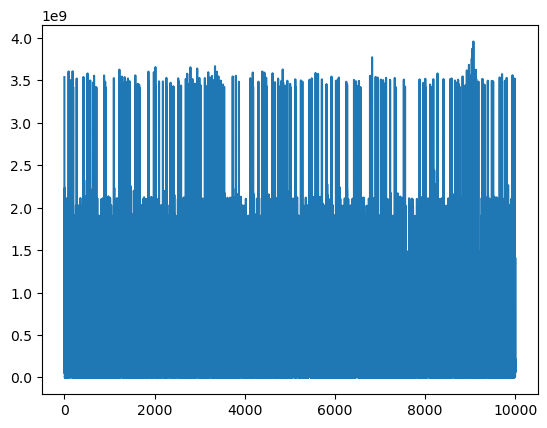

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [50]:
all_losses

[3537779968.0,
 52087040.0,
 739123968.0,
 134011416.0,
 58618928.0,
 53172072.0,
 2038344064.0,
 2232383488.0,
 50635036.0,
 219600656.0,
 9731.58203125,
 10399196.0,
 13134.0234375,
 587443.875,
 1316208000.0,
 104742800.0,
 17942.39453125,
 51624680.0,
 2025640960.0,
 48745196.0,
 17717.65625,
 211975488.0,
 6219492.5,
 14791199.0,
 738350272.0,
 1906494592.0,
 2026879616.0,
 48690200.0,
 1418680448.0,
 245233440.0,
 220311568.0,
 1411124608.0,
 158348528.0,
 1404881920.0,
 51752000.0,
 129586088.0,
 670452864.0,
 16440.0078125,
 230008.203125,
 73086936.0,
 13476.3173828125,
 158178976.0,
 1907379328.0,
 268799.5625,
 24607650.0,
 13440.67578125,
 256798864.0,
 57557480.0,
 218920032.0,
 1908083712.0,
 56958440.0,
 739427520.0,
 135813408.0,
 265505.84375,
 23269526.0,
 73107664.0,
 23282802.0,
 6214835.0,
 3547.06689453125,
 1904143744.0,
 1903965056.0,
 2114052352.0,
 55403844.0,
 249212384.0,
 55086040.0,
 7138525.5,
 133231672.0,
 16016.4951171875,
 23479460.0,
 219810096.0,
 4

# Running one unseen inputs

In [51]:
# Just return an output given an input
def evaluate(x):
    hidden = model.initHidden()
    result = []
    
    for i in range(x.size()[0]):
        output, hidden = model(x[i], hidden)
        result.append(output)

    return result

In [52]:
def predict(x):
    with torch.no_grad():
        result = evaluate(x)
    return result

In [53]:
results = []
for index in range(len(testSet)):
    x = testSet[index]
    output = predict(x)
    results.append(output)

In [54]:
results[0]

[tensor([[62.2832]]),
 tensor([[114.5105]]),
 tensor([[136.7684]]),
 tensor([[170.2339]])]